This notebook illustrates the workflow to calculate variogram of 

In [1]:
import tkinter as tk

class Calculator:
    def __init__(self, root):
        self.root = root
        self.root.title("Simple Calculator")
        
        self.result_var = tk.StringVar()
        self.result_var.set("0")
        
        self.create_widgets()
        
    def create_widgets(self):
        # Create result display
        result_entry = tk.Entry(self.root, textvariable=self.result_var, font=('Arial', 20), bd=10, insertwidth=2, width=14, borderwidth=4)
        result_entry.grid(row=0, column=0, columnspan=4)
        
        # Create buttons
        buttons = [
            '7', '8', '9', '/',
            '4', '5', '6', '*',
            '1', '2', '3', '-',
            '0', '.', '=', '+'
        ]
        
        row_val = 1
        col_val = 0
        
        for button in buttons:
            tk.Button(self.root, text=button, padx=20, pady=20, font=('Arial', 18), command=lambda b=button: self.on_button_click(b)).grid(row=row_val, column=col_val)
            col_val += 1
            if col_val > 3:
                col_val = 0
                row_val += 1

    def on_button_click(self, button):
        current_text = self.result_var.get()
        
        if button == "=":
            try:
                result = eval(current_text)
                self.result_var.set(result)
            except Exception as e:
                self.result_var.set("Error")
        elif button == "C":
            self.result_var.set("")
        else:
            if current_text == "0":
                self.result_var.set(button)
            else:
                self.result_var.set(current_text + button)
                
if __name__ == "__main__":
    root = tk.Tk()
    calculator = Calculator(root)
    root.mainloop()

In [11]:
# Add python script files to the system env
import sys  
sys.path.insert(1, "..\\My Functions")
# 
import numpy as np
import pandas as pd
import rasterio as rio
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
# Import the custom python script files
import my_Variogram
import my_RomanMetrics
import my_Variogram_Plot

In [12]:
# \\DISC
cwd = "..\\..\\"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed"
cwd_Images_Results = cwd + "\\Results"

In [13]:
df_HI = pd.read_excel(cwd_Images_Results + "\\HI Average MinMaxOnEachROI with Mean, CV and Sill (91 Sites).xlsx", header=1)
df_HI = df_HI[['Site','HI Total','Variogram Fit']]
df_Roman = pd.read_excel(cwd_Images_Results + "\\Roman RAW and ST Score (91 Sites).xlsx")
df = pd.merge(df_Roman,df_HI,on = 'Site')
df.to_csv(cwd_Images_Results + "\\Merge.csv", index = False)

In [14]:
name_Site = "Robson Creek rainforest"

In [36]:
df = pd.read_csv(cwd + f"\\GEE {name_Site}.csv")
df

,Date,CV,Sill
0,20230121,0.101557,48.347135
1,20230123,0.178041,2.469366
2,20230202,0.107435,46.471934
3,20230302,0.117443,42.922853
4,20230304,-0.208565,0.671741
...,...,...,...
62,20231117,0.078989,32.127553
63,20231202,0.068311,17.349501
64,20231224,0.074763,35.286227
65,20231227,-0.861115,24.753393


In [37]:
df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df

,Date,CV,Sill
0,2023-01-21,0.101557,48.347135
1,2023-01-23,0.178041,2.469366
2,2023-02-02,0.107435,46.471934
3,2023-03-02,0.117443,42.922853
4,2023-03-04,-0.208565,0.671741
...,...,...,...
62,2023-11-17,0.078989,32.127553
63,2023-12-02,0.068311,17.349501
64,2023-12-24,0.074763,35.286227
65,2023-12-27,-0.861115,24.753393


C:\Users\m1865\AppData\Local\Temp\ipykernel_1552\3096204957.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  k = k[np.abs(stats.zscore(df['Sill'])) < 1]


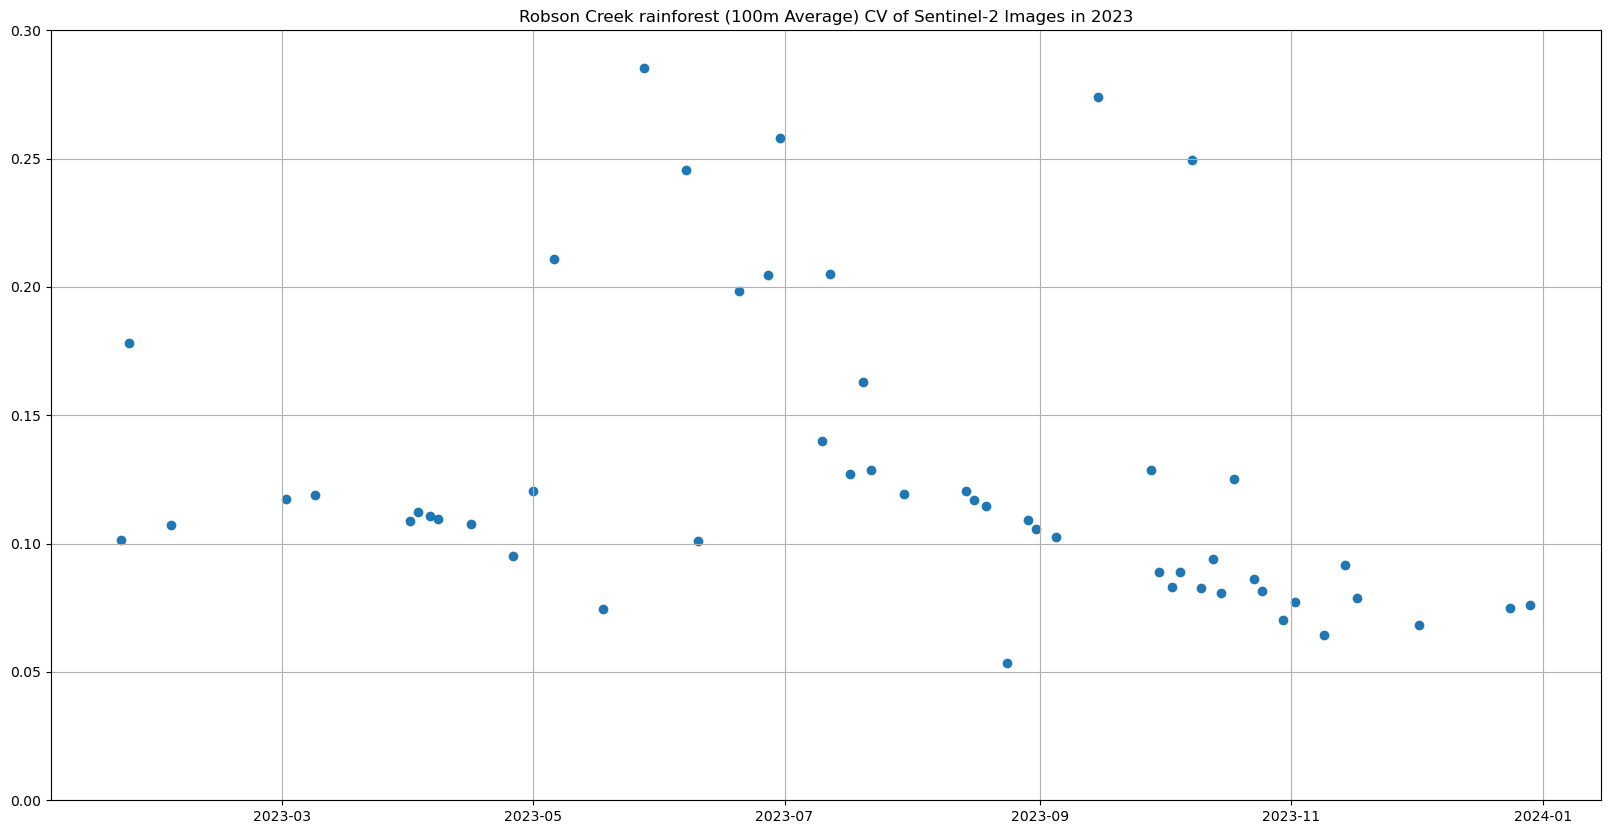

In [41]:
from scipy import stats
k = df[np.abs(stats.zscore(df['CV'])) < 1]
k = k[np.abs(stats.zscore(df['Sill'])) < 1]
plt.figure(figsize = (20,10))
plt.title(f"{name_Site} (100m Average) CV of Sentinel-2 Images in 2023")
plt.scatter(k['Date'], k['CV'], label = "CV")
plt.ylim(0,0.3)
plt.grid()

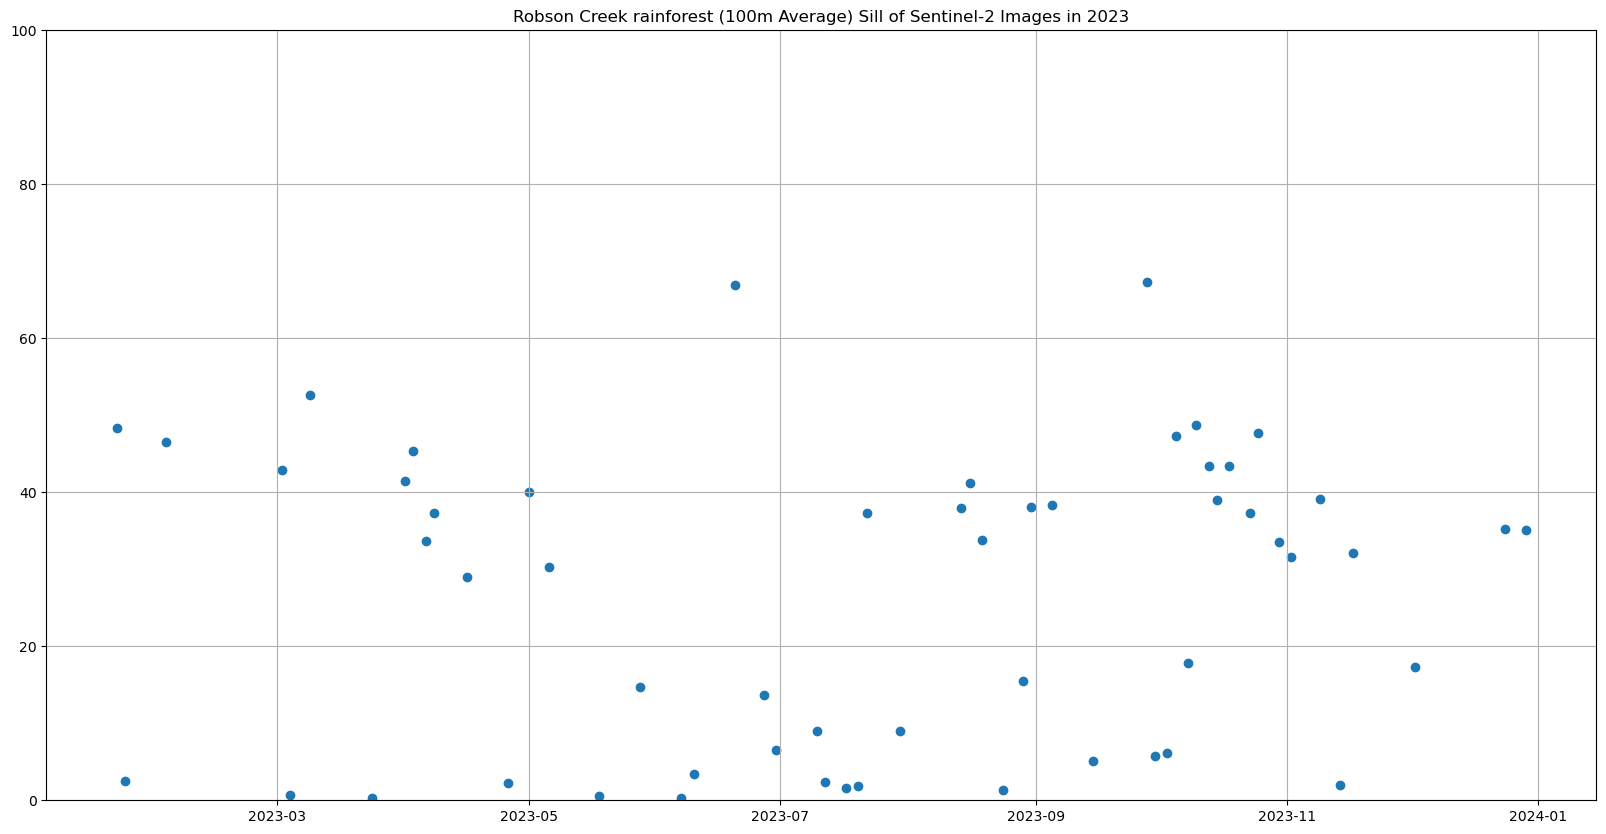

In [42]:
plt.figure(figsize = (20,10))
plt.title(f"{name_Site} (100m Average) Sill of Sentinel-2 Images in 2023")
plt.scatter(k['Date'], k['Sill'], label = "Sill")
plt.ylim(0,100)
plt.grid()

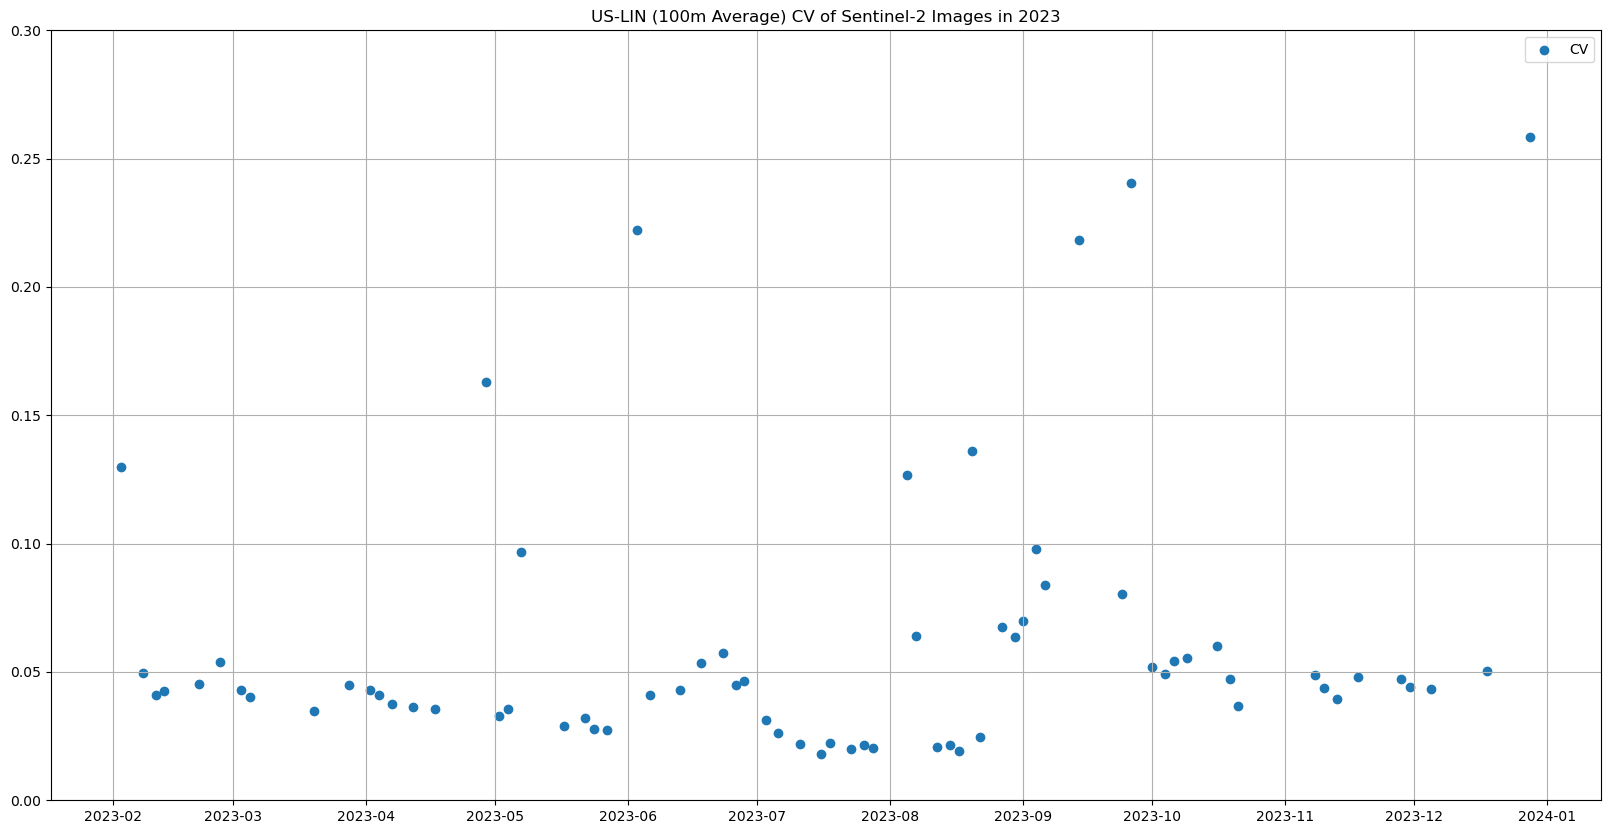

In [16]:

m = df[np.abs(stats.zscore(df['CV'])) < 1]
m = m.groupby("Date").mean().reset_index(drop = False)  
plt.figure(figsize = (20,10))
plt.title(f"{name_Site} (100m Average) CV of Sentinel-2 Images in 2023")
plt.scatter(m['Date'], m['CV'], label = "CV")
plt.ylim(0,0.3)
plt.legend()
plt.grid()

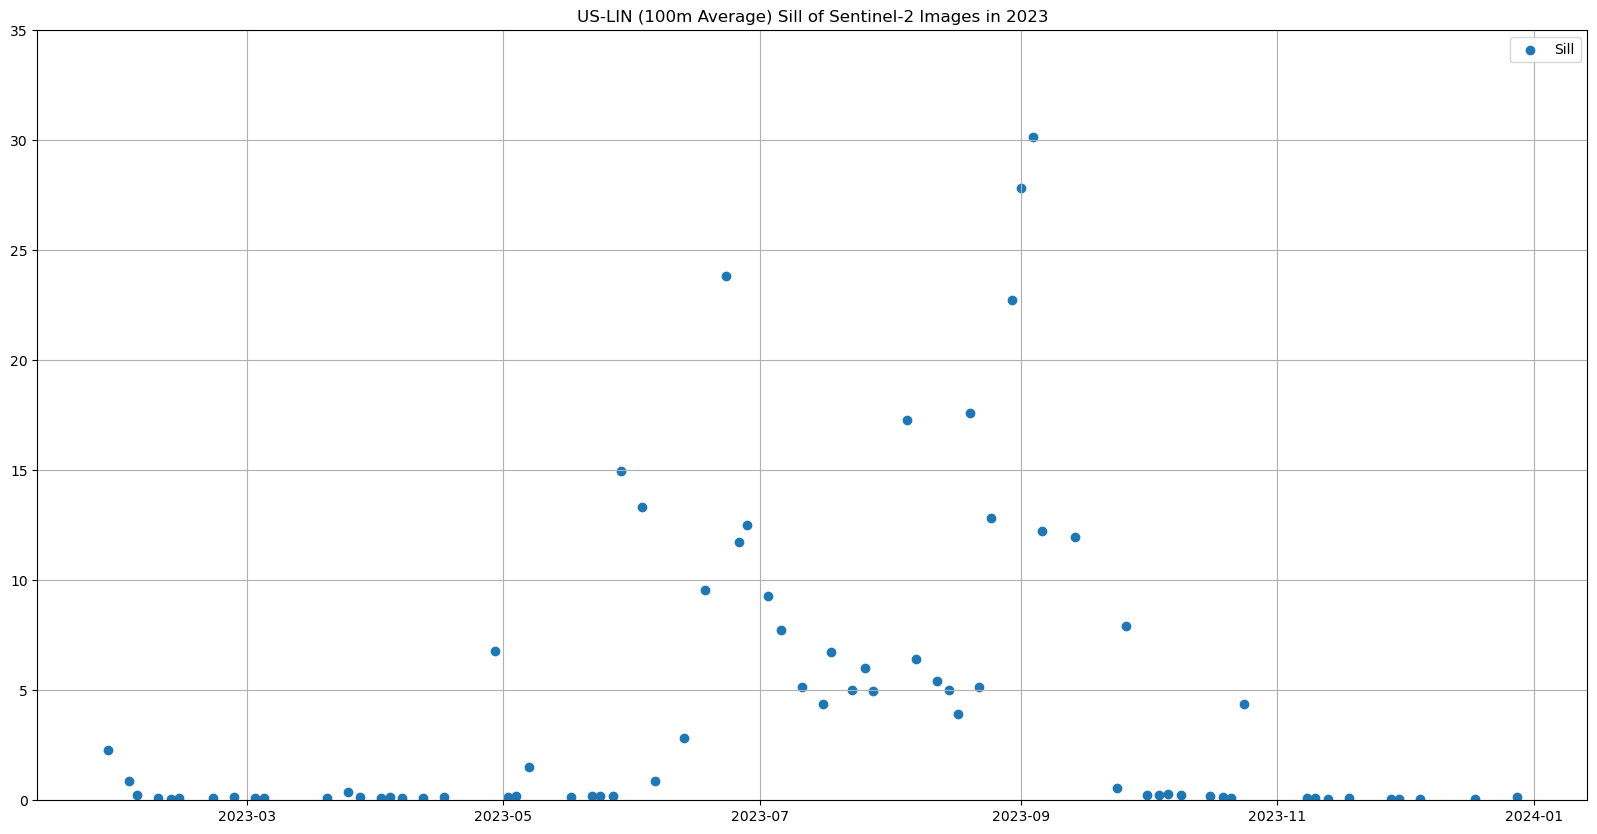

In [17]:
from scipy import stats
n = df[np.abs(stats.zscore(df['Sill'])) < 1]
n = n.groupby("Date").mean().reset_index(drop = False)  
plt.figure(figsize = (20,10))
plt.title(f"{name_Site} (100m Average) Sill of Sentinel-2 Images in 2023")
plt.scatter(n['Date'], n['Sill'], label = "Sill")
plt.ylim(0,35)
plt.legend()
plt.grid()

In [8]:
list_DayofYear = []
for i in range(m.shape[0]):
    temp_DoY = pd.Period(m['Date'].iloc[i], freq = 'D').day_of_year
    list_DayofYear.append(temp_DoY)
list_DayofYear[-5:]

[322, 332, 334, 339, 352]

In [9]:
list_DayofYear_Sill = []
for i in range(n.shape[0]):
    temp_DoY = pd.Period(n['Date'].iloc[i], freq = 'D').day_of_year
    list_DayofYear_Sill.append(temp_DoY)
list_DayofYear_Sill[-5:]

[269, 274, 277, 279, 297]

In [10]:
df_Cubic = pd.DataFrame({
    "Date": m['Date'],
    "DoY": list_DayofYear,
    "CV": m['CV'],
    "Sill": m["Sill"]
})
df_Cubic[-5:]

,Date,DoY,CV,Sill
62,2023-11-18,322,0.048030,0.093596
63,2023-11-28,332,0.047235,0.072717
64,2023-11-30,334,0.044087,0.075677
65,2023-12-05,339,0.043408,0.067008
66,2023-12-18,352,0.050488,0.074265


In [11]:
df_Cubic_Sill = pd.DataFrame({
    "Date": n['Date'],
    "DoY": list_DayofYear_Sill,
    "CV": n['CV'],
    "Sill": n["Sill"]
})
df_Cubic_Sill

,Date,DoY,CV,Sill
0,2023-01-27,27,1.959619,2.280948
1,2023-02-01,32,0.395842,0.878195
2,2023-02-03,34,0.129975,0.228750
3,2023-03-25,84,-0.126437,0.379574
4,2023-04-29,119,0.163156,6.763853
5,2023-05-07,127,0.096612,1.516714
6,2023-05-29,149,0.471332,14.972033
7,2023-06-03,154,0.222131,13.343646
8,2023-06-06,157,0.041036,0.891708
9,2023-06-13,164,0.043062,2.853321


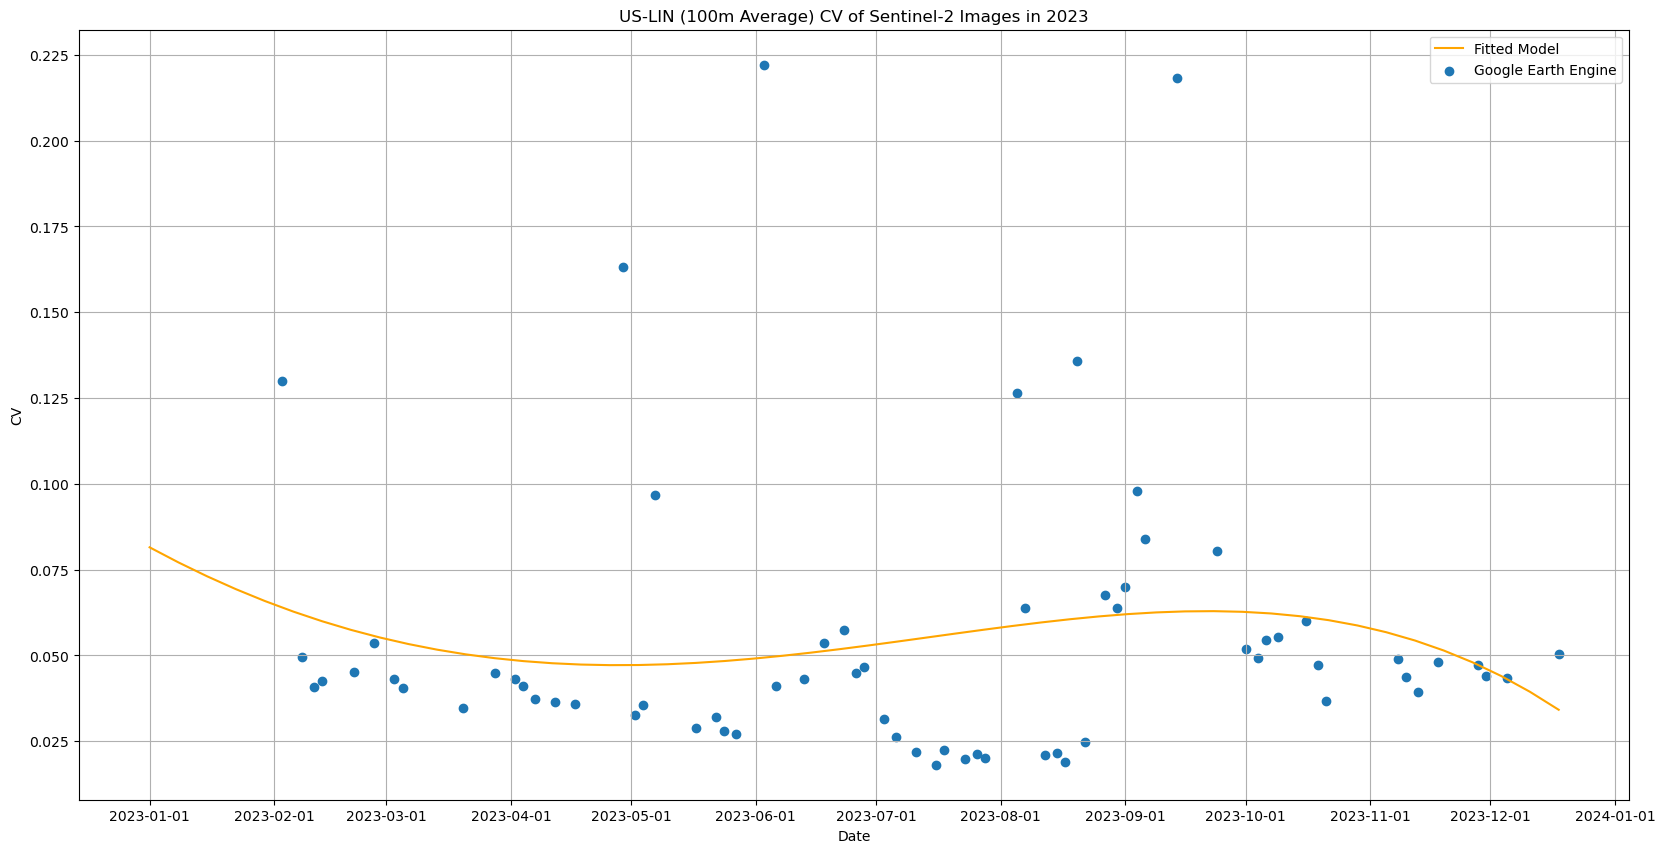

In [12]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title(f"{name_Site} (100m Average) CV of Sentinel-2 Images in 2023")
#fit cubic regression model
model = np.poly1d(np.polyfit(df_Cubic.DoY, df_Cubic.CV, 4))

#add fitted cubic regression line to scatterplot
polyline = np.linspace(1, df_Cubic.DoY.iloc[-1])

plt.plot(polyline, model(polyline), color = 'Orange', label = 'Fitted Model')
plt.scatter(df_Cubic.DoY, df_Cubic.CV, label = 'Google Earth Engine')

# update_ticks
ax.set_xticks([1,32,60,91,121,152,182,213,244,274,305,335,366])
ax.set_xticklabels(['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01','2023-06-01','2023-07-01','2023-08-01','2023-09-01','2023-10-01','2023-11-01','2023-12-01','2024-01-01'])

#add axis labels
plt.xlabel('Date')
plt.ylabel('CV')

#display plot
plt.legend()
plt.grid()
plt.show()

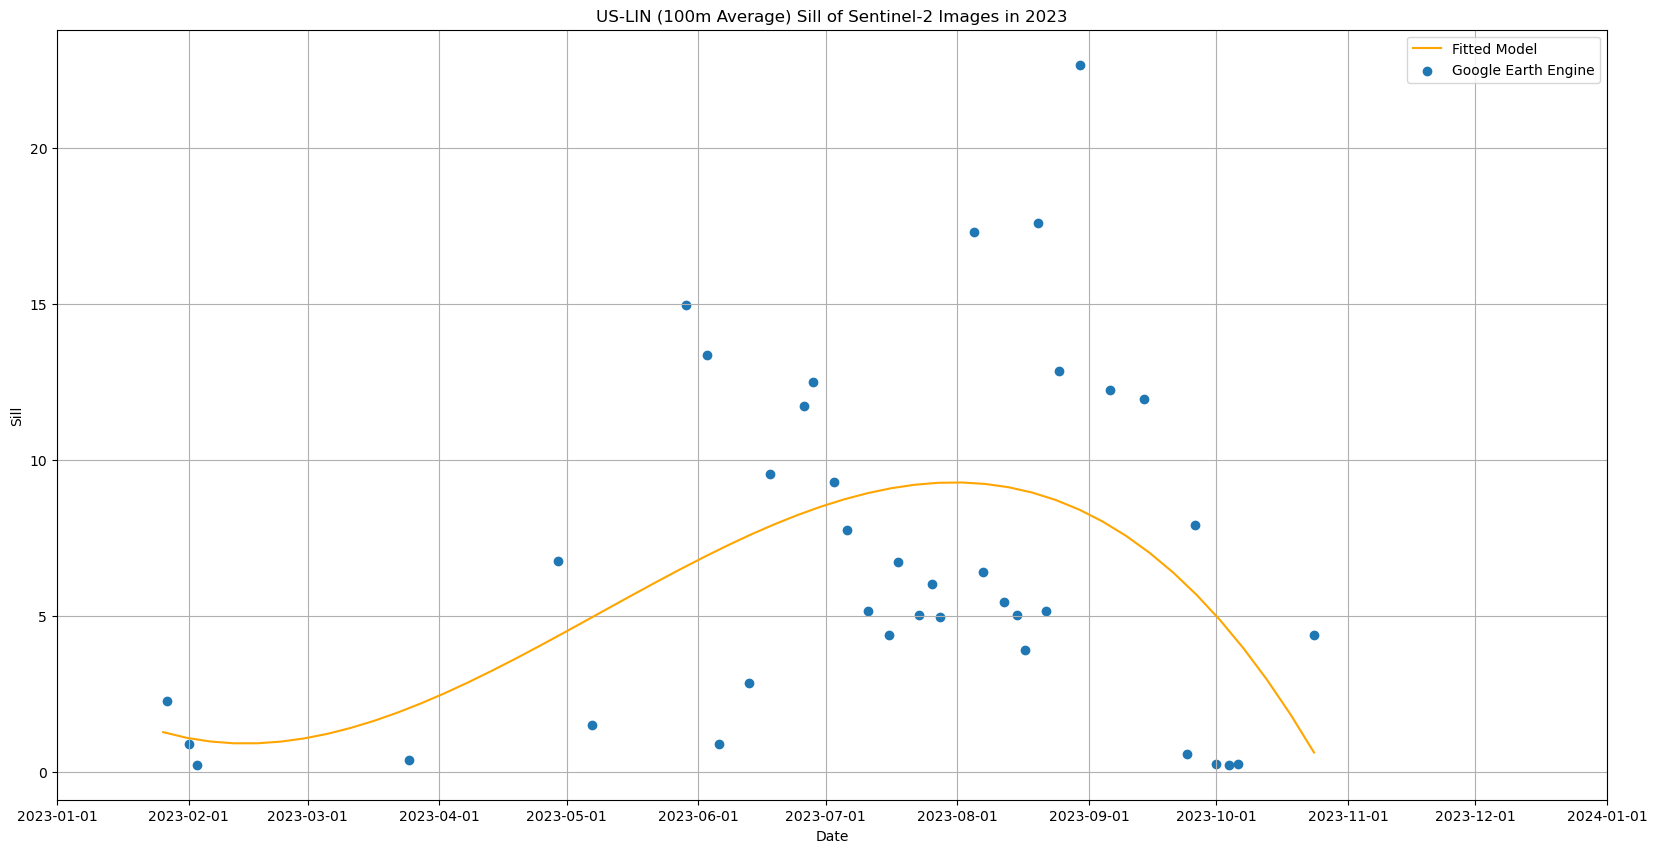

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title(f"{name_Site} (100m Average) Sill of Sentinel-2 Images in 2023")
#fit cubic regression model
model = np.poly1d(np.polyfit(df_Cubic_Sill.DoY, df_Cubic_Sill.Sill, 3))

#add fitted cubic regression line to scatterplot
polyline = np.linspace(26, df_Cubic_Sill.DoY.iloc[-1])

plt.plot(polyline, model(polyline), color = 'Orange', label = 'Fitted Model')
plt.scatter(df_Cubic_Sill.DoY, df_Cubic_Sill.Sill, label = 'Google Earth Engine')

# update_ticks
ax.set_xticks([1,32,60,91,121,152,182,213,244,274,305,335,366])
ax.set_xticklabels(['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01','2023-06-01','2023-07-01','2023-08-01','2023-09-01','2023-10-01','2023-11-01','2023-12-01','2024-01-01'])

#add axis labels
plt.xlabel('Date')
plt.ylabel('Sill')

#display plot
plt.legend()
plt.grid()
plt.show()

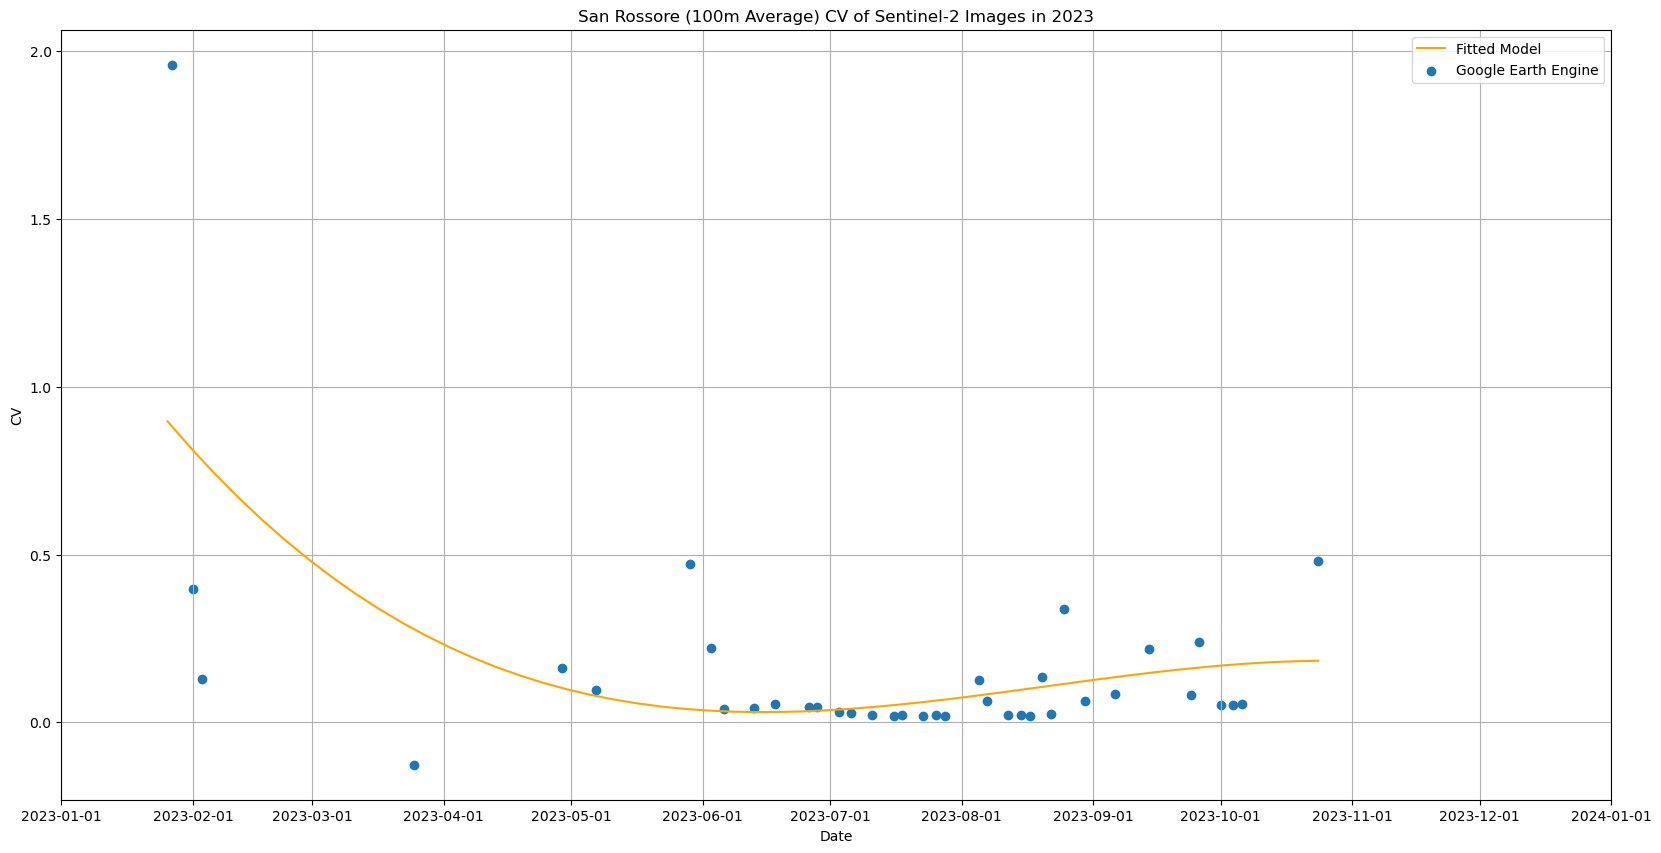

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title(f"San Rossore (100m Average) CV of Sentinel-2 Images in 2023")
#fit cubic regression model
model = np.poly1d(np.polyfit(df_Cubic_Sill.DoY, df_Cubic_Sill.CV, 3))

#add fitted cubic regression line to scatterplot
polyline = np.linspace(26, df_Cubic_Sill.DoY.iloc[-1])

plt.plot(polyline, model(polyline), color = 'Orange', label = 'Fitted Model')
plt.scatter(df_Cubic_Sill.DoY, df_Cubic_Sill.CV, label = 'Google Earth Engine')

# update_ticks
ax.set_xticks([1,32,60,91,121,152,182,213,244,274,305,335,366])
ax.set_xticklabels(['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01','2023-06-01','2023-07-01','2023-08-01','2023-09-01','2023-10-01','2023-11-01','2023-12-01','2024-01-01'])

#add axis labels
plt.xlabel('Date')
plt.ylabel('CV')

#display plot
plt.legend()
plt.grid()
plt.show()

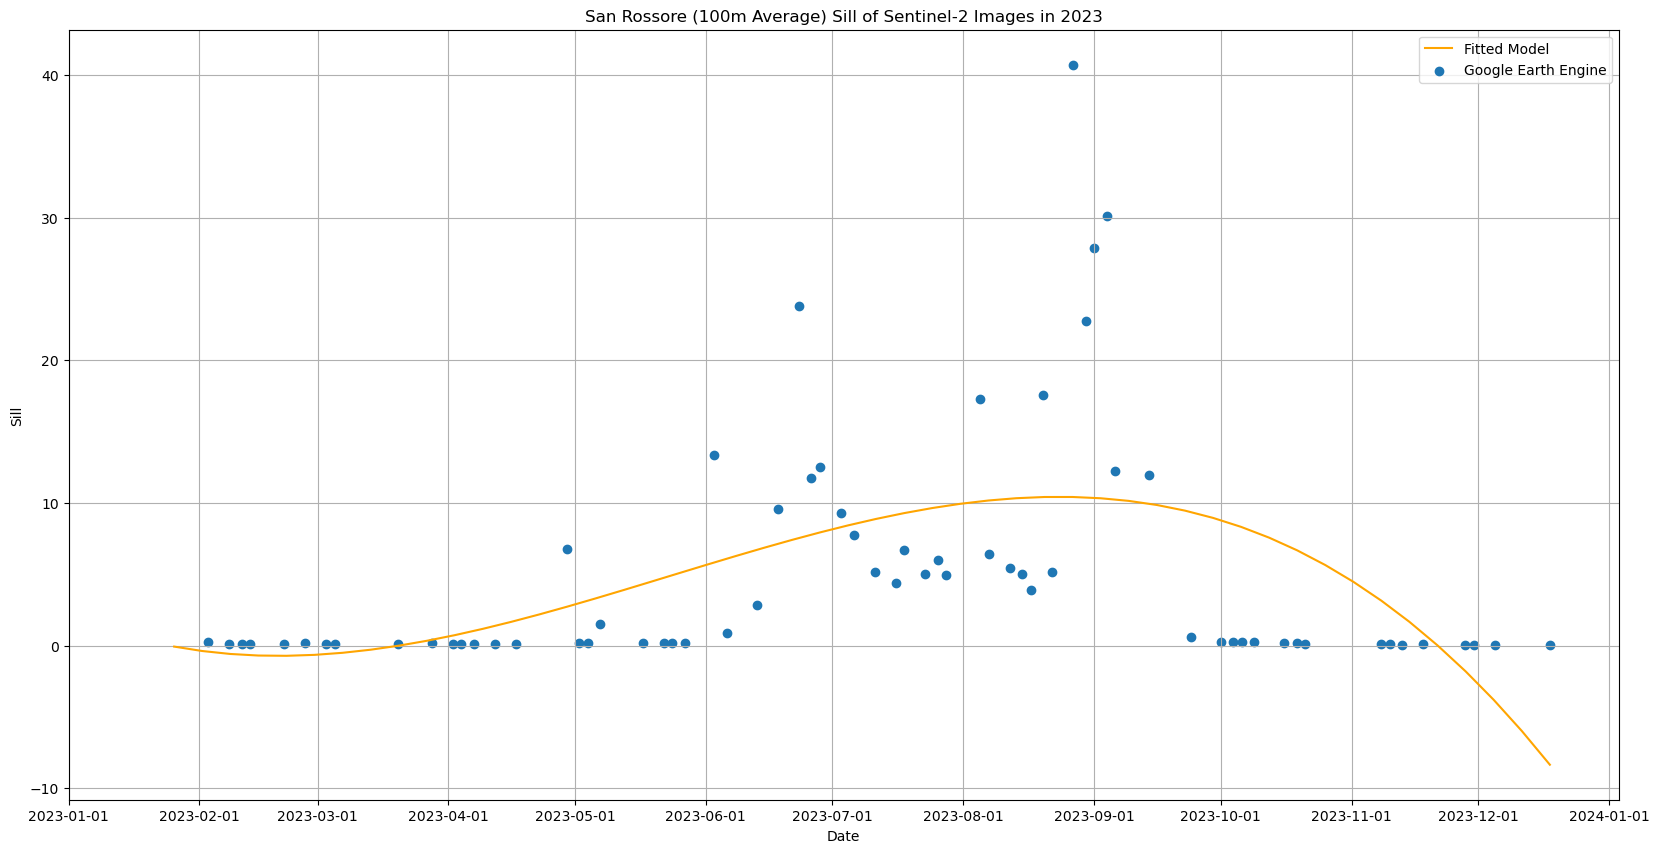

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.title(f"{site} (100m Average) Sill of Sentinel-2 Images in 2023")
#fit cubic regression model
model = np.poly1d(np.polyfit(df_Cubic.DoY, df_Cubic.Sill, 3))

#add fitted cubic regression line to scatterplot
polyline = np.linspace(26, df_Cubic.DoY.iloc[-1])

plt.plot(polyline, model(polyline), color = 'Orange', label = 'Fitted Model')
plt.scatter(df_Cubic.DoY, df_Cubic.Sill, label = 'Google Earth Engine')

# update_ticks
ax.set_xticks([1,32,60,91,121,152,182,213,244,274,305,335,366])
ax.set_xticklabels(['2023-01-01','2023-02-01','2023-03-01','2023-04-01','2023-05-01','2023-06-01','2023-07-01','2023-08-01','2023-09-01','2023-10-01','2023-11-01','2023-12-01','2024-01-01'])

#add axis labels
plt.xlabel('Date')
plt.ylabel('Sill')

#display plot
plt.legend()
plt.grid()
plt.show()

In [144]:
# Sample DataFrame
df = pd.DataFrame({
    "date": ["2024-01-01 23:59:59","2024-01-28 00:00:00","2024-05-01 01:00:00","2024-11-30 12:30:00"]
})

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

In [145]:
# Extract various datetime properties
df['date_only'] = df['date'].dt.date
df['time_only'] = df['date'].dt.time
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second
df['dayofweek'] = df['date'].dt.dayofweek
df['dayofyear'] = df['date'].dt.dayofyear
df['week'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter

# Print
df

,date,date_only,time_only,year,month,day,hour,minute,second,dayofweek,dayofyear,week,quarter
0,2024-01-01 23:59:59,2024-01-01,23:59:59,2024,1,1,23,59,59,0,1,1,1
1,2024-01-28 00:00:00,2024-01-28,00:00:00,2024,1,28,0,0,0,6,28,4,1
2,2024-05-01 01:00:00,2024-05-01,01:00:00,2024,5,1,1,0,0,2,122,18,2
3,2024-11-30 12:30:00,2024-11-30,12:30:00,2024,11,30,12,30,0,5,335,48,4


In [139]:
df['weekofyear'] = df['date'].dt.isocalendar().week
df

,date,year,month,day,hour,minute,second,dayofweek,dayofyear,week,quarter,weekofyear
0,2024-01-01,2024,1,1,0,0,0,0,1,1,1,1
1,2024-01-28,2024,1,28,0,0,0,6,28,4,1,4
2,2024-05-01,2024,5,1,0,0,0,2,122,18,2,18
3,2024-11-30,2024,11,30,0,0,0,5,335,48,4,48


In [142]:
df['ismonthstart'] = df['date'].dt.is_month_start
df

,date,ismonthstart
0,2024-01-01,True
1,2024-01-28,False
2,2024-05-01,True
3,2024-11-30,False


In [70]:
cwd_Image_Folder = cwd + "\\Sentinel-2 Images Processed\\US-LIN"

In [71]:
# Set g
g = 4.66

In [72]:
# Set internal distance
distances_Int = [30,30,100,300,300,300]
# Set external distance
distances_Ext = [100,300,300,600,900,1200]

In [73]:
# Get the unique distances so we can calculate the variogram first
list_distances = list(set(distances_Int + distances_Ext))
list_distances.sort()
list_distances

[30, 100, 300, 600, 900, 1200]

In [74]:
list_std = []
list_cv = []
list_range = []
list_nugget = []
list_sill = []
list_bins = []
list_experimental_model = []
list_fitted_model = []
list_empiral_X = []
list_empiral_Y = []
for i in range(len(list_distances)):
    img = rio.open(cwd_Image_Folder + "\\NIRv " + str(list_distances[i]) + "m.tif")
    band = img.read(1).reshape(-1)
    temp_std = my_Variogram.calc_STD(band)
    temp_cv = my_Variogram.calc_CV(band)
    coordinates = my_Variogram.get_Coordinates_from_Rio(img)
    temp_range, temp_nugget, temp_sill, temp_bins, temp_experimental_model, temp_fitted_model, temp_empiral_X, temp_empiral_Y = my_Variogram.calc_Variogram_Parameters(band,coordinates,list_distances[i])
    list_std.append(temp_std)
    list_cv.append(temp_cv)
    list_range.append(temp_range)
    list_nugget.append(temp_nugget)
    list_sill.append(temp_sill)
    list_bins.append(temp_bins)
    list_experimental_model.append(temp_experimental_model)
    list_fitted_model.append(temp_fitted_model)
    list_empiral_X.append(temp_empiral_X)
    list_empiral_Y.append(temp_empiral_Y)
    print(f"Distance {list_distances[i]} has been calculated!")

c:\ProgramData\anaconda3\envs\DISC\Lib\site-packages\skgstat\Variogram.py:1715: OptimizeWarning: Covariance of the parameters could not be estimated
  self.cof, self.cov = curve_fit(


Distance 30 has been calculated!
Distance 100 has been calculated!
Distance 300 has been calculated!
Distance 600 has been calculated!
Distance 900 has been calculated!
Distance 1200 has been calculated!


In [75]:
# Make a dataframe to illustrate the numeric result of variograms
df_Vario = pd.DataFrame({
    "Distance": list_distances,
    "STD": list_std,
    "CV": list_cv,
    "Range": list_range,
    "Sill": list_sill,
    "Nugget": list_nugget
})
df_Vario

,Distance,STD,CV,Range,Sill,Nugget
0,30,0.844591,0.008956,20.000000,0.626820,3.118349e-01
1,100,1.803579,0.019019,65.576055,3.883706,6.266085e-31
2,300,5.390128,0.057523,210.000000,31.142912,6.796741e+00
3,600,4.484857,0.048321,157.755668,21.122576,4.401695e+00
4,900,18.635796,0.211051,630.000000,347.913864,1.051105e+02
5,1200,31.965300,0.358960,836.615153,1041.065977,3.253057e+02


In [76]:
list_Rcv = []
list_RAW_Score = []
list_Rse = []
list_Rst = []
list_Rsv = []
list_ST_Score = []
for i in range(len(list_distances)):
    dist_Int = distances_Int[i]
    dist_Ext = distances_Ext[i]
    index_Int = list_distances.index(dist_Int)
    index_Ext = list_distances.index(dist_Ext)
    range_Int, nugget_Int, sill_Int, bins_Int, experimental_model_Int, fitted_model_Int = list_range[index_Int], list_nugget[index_Int], list_sill[index_Int], list_bins[index_Int], list_experimental_model[index_Int], list_fitted_model[index_Int]
    range_Ext, nugget_Ext, sill_Ext, bins_Ext, experimental_model_Ext, fitted_model_Ext = list_range[index_Ext], list_nugget[index_Ext], list_sill[index_Ext], list_bins[index_Ext], list_experimental_model[index_Ext], list_fitted_model[index_Ext]
    cv_Int = list_cv[index_Int]
    cv_Ext = list_cv[index_Ext]
    semivar_range_Exp_Int = my_Variogram.get_Semivar_Exp(dist_Int, bins_Int, experimental_model_Int)
    semivar_range_Exp_Ext = my_Variogram.get_Semivar_Exp(dist_Ext, bins_Ext, experimental_model_Ext)
    # Calculate Rcv
    Rcv = my_RomanMetrics.calc_Rcv(cv_Ext, cv_Int)
    # Calculate RAW Score
    RAW_Score = my_RomanMetrics.calc_RAWScore(Rcv)
    # Calculate Rse
    Rse = my_RomanMetrics.calc_Rse(g, range_Ext, range_Int)
    # Calculate Rst
    Rst = my_RomanMetrics.calc_Rst(my_RomanMetrics.calc_ST(semivar_range_Exp_Ext, nugget_Ext), my_RomanMetrics.calc_ST(semivar_range_Exp_Int, nugget_Int))
    # Calculate Rsv
    Rsv = my_RomanMetrics.calc_Rsv(my_RomanMetrics.calc_SV(fitted_model_Ext, range_Ext, nugget_Ext, sill_Ext), my_RomanMetrics.calc_SV(fitted_model_Int, range_Int, nugget_Int, sill_Int))
    # Calculate ST Score
    ST_Score = my_RomanMetrics.calc_STScore(Rcv, Rse, Rst, Rsv)
    list_Rcv.append(Rcv)
    list_RAW_Score.append(RAW_Score)
    list_Rse.append(Rse)
    list_Rst.append(Rst)
    list_Rsv.append(Rsv)
    list_ST_Score.append(ST_Score)
    print(f"Internal distance {dist_Int} and external distance {dist_Ext} has been computed!")


Internal distance 30 and external distance 100 has been computed!
Internal distance 30 and external distance 300 has been computed!
Internal distance 100 and external distance 300 has been computed!
Internal distance 300 and external distance 600 has been computed!
Internal distance 300 and external distance 900 has been computed!
Internal distance 300 and external distance 1200 has been computed!


In [77]:
# Make a dataframe to illustrate the numeric result of roman metrics
df_Roman = pd.DataFrame({
    "Internal Distance": distances_Int,
    "External Distance": distances_Ext,
    "Rcv": list_Rcv,
    "Rse": list_Rse,
    "Rst": list_Rst,
    "Rsv": list_Rsv,
    "RAW Score": list_RAW_Score,
    "ST Score": list_ST_Score
})
df_Roman

,Internal Distance,External Distance,Rcv,Rse,Rst,Rsv,RAW Score,ST Score
0,30,100,1.123471,0.783804,0.990000,5.524818,0.445049,0.300309
1,30,300,5.422610,0.791319,0.583290,15.334800,0.092207,0.126504
2,100,300,2.024581,0.928257,-0.204377,1.503488,0.246965,0.460319
3,300,600,-0.159978,0.963728,0.004123,-0.239312,3.125431,0.910581
4,300,900,2.668961,0.976881,-0.088192,1.678137,0.187339,0.407280
5,300,1200,5.240244,0.977381,-0.106323,2.503679,0.095415,0.278231


In [78]:
df_Vario.to_csv(cwd_Image_Folder + "\\Vario.csv", index = False)
df_Roman.to_csv(cwd_Image_Folder + "\\Roman.csv", index = False)

In [81]:
my_Variogram_Plot.plot_Variogram(list_distances, list_bins, list_fitted_model, list_range, list_sill, list_nugget, list_empiral_X,list_empiral_Y, site_Name_Graph = cwd_Image_Folder.split("\\")[-1], path_SaveFig = cwd_Image_Folder + "\\Variogram.png", bool_SaveFig = True, bool_CloseFig = True)